In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib

### **Loading The Ravdess Dataset**

### Example: 03-01-01-01-01-01-02.wav, there are 7 different identifiers here. The 3rd part i.e. ('01') shows the type of emotion, 4th part ('01') showing the intensity of the particular emotion and the 7th part indicates whether the actor is female or male(even number=female, odd number=Male)

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Colab Notebooks',
 'BIG DATA',
 'DL_Project',
 'GWAR_Project',
 'ML_Project',
 'Copy of Project1.ipynb',
 'angry.wav',
 '.ipynb_checkpoints']

In [7]:
base_dir = '/content/drive/MyDrive/ML_Project/Source Dataset'

In [8]:
data = []
for actor in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion = file.split('_')[0]
                data.append({
                    'FilePath': os.path.join(actor_path, file),
                    'Emotion': emotion,
                    'Actor': actor
                })

In [9]:
df = pd.DataFrame(data)
print(df.head())

                                            FilePath  \
0  /content/drive/MyDrive/ML_Project/Source Datas...   
1  /content/drive/MyDrive/ML_Project/Source Datas...   
2  /content/drive/MyDrive/ML_Project/Source Datas...   
3  /content/drive/MyDrive/ML_Project/Source Datas...   
4  /content/drive/MyDrive/ML_Project/Source Datas...   

                    Emotion     Actor  
0  03-01-01-01-02-01-07.wav  Actor_07  
1  03-01-01-01-01-01-07.wav  Actor_07  
2  03-01-01-01-01-02-07.wav  Actor_07  
3  03-01-01-01-02-02-07.wav  Actor_07  
4  03-01-02-01-02-02-07.wav  Actor_07  


### **Exploratory** **Data** **Analysis** & **Visualisations**

Emotion
03-01-01-01-02-01-07.wav    1
03-01-03-01-01-02-19.wav    1
03-01-03-02-02-02-19.wav    1
03-01-03-02-01-02-19.wav    1
03-01-03-01-02-01-19.wav    1
                           ..
03-01-08-01-01-01-08.wav    1
03-01-08-01-02-01-08.wav    1
03-01-07-02-02-01-08.wav    1
03-01-08-02-01-01-08.wav    1
03-01-06-01-02-01-11.wav    1
Name: count, Length: 1456, dtype: int64


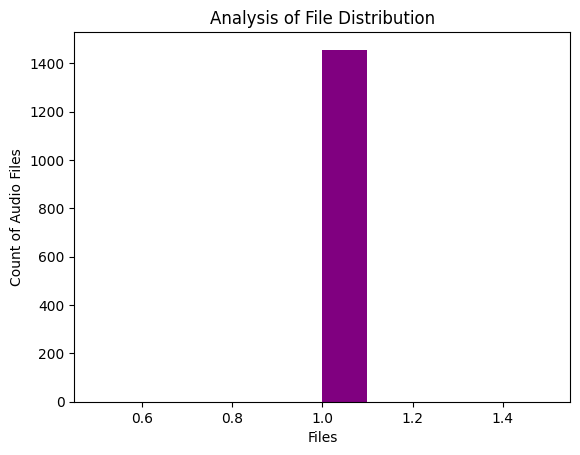

Emotion
03-01-01-01-02-01-07.wav    1
03-01-03-01-01-02-19.wav    1
03-01-03-02-02-02-19.wav    1
03-01-03-02-01-02-19.wav    1
03-01-03-01-02-01-19.wav    1
                           ..
03-01-08-01-01-01-08.wav    1
03-01-08-01-02-01-08.wav    1
03-01-07-02-02-01-08.wav    1
03-01-08-02-01-01-08.wav    1
03-01-06-01-02-01-11.wav    1
Name: count, Length: 1456, dtype: int64


In [10]:
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)
emotion_counts.plot(kind='hist', color='purple')
plt.title('Analysis of File Distribution')
plt.xlabel('Files')
plt.ylabel('Count of Audio Files')
plt.show()
min_count = emotion_counts.min()
balanced_df = pd.concat([df[df['Emotion'] == emotion].sample(min_count, random_state=42) for emotion in df['Emotion'].unique()])
print(balanced_df['Emotion'].value_counts())

## Checking A Sample File

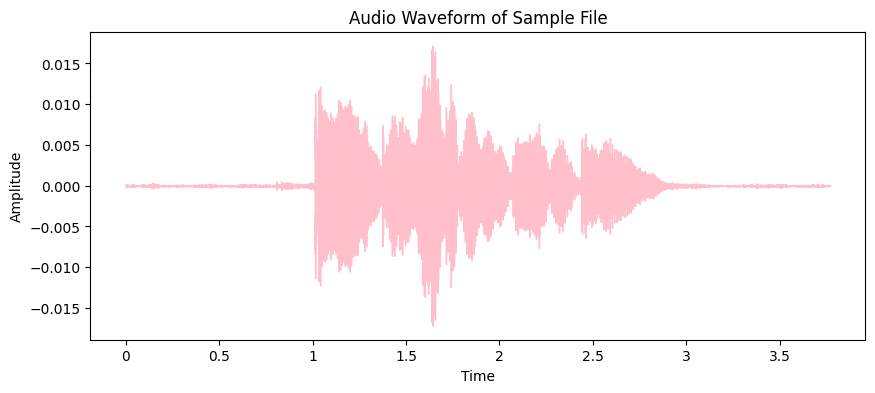

In [11]:
file_path = '/content/drive/MyDrive/ML_Project/Source Dataset/Actor_11/03-01-02-02-02-01-11.wav'
y, sr = librosa.load(file_path, sr=None)
plt.figure(figsize=(10,4))
librosa.display.waveshow(y, sr=sr,color='pink')
plt.title('Audio Waveform of Sample File')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

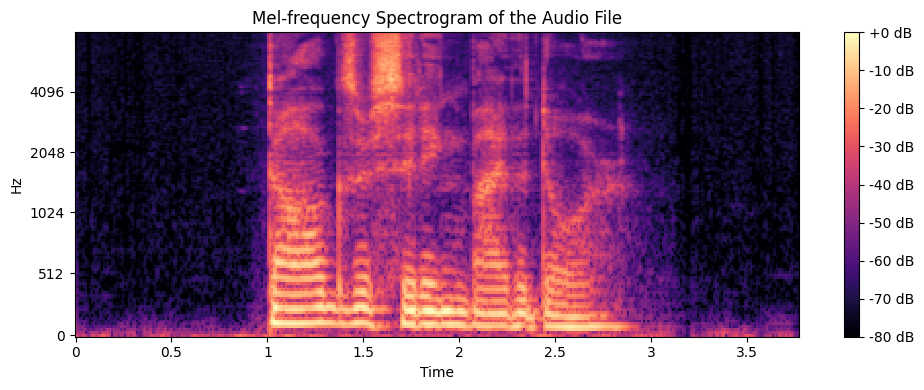

In [12]:
S_audio = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S_audio, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency Spectrogram of the Audio File')
plt.tight_layout()
plt.show()

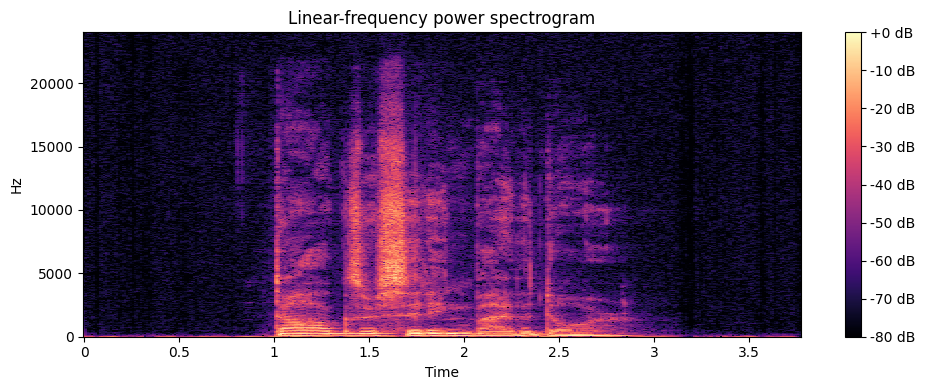

In [13]:
#Linear frequency
D_audio = np.abs(librosa.stft(y))
D_dB = librosa.amplitude_to_db(D_audio, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D_dB, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.tight_layout()
plt.show()

### **Feature** **Extraction**

In [14]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(S=librosa.stft(y), sr=sr)
    tonnetz = librosa.effects.harmonic(y=y)
    tonnetz = librosa.feature.tonnetz(y=tonnetz, sr=sr)
    features = np.hstack([np.mean(feature, axis=1) for feature in [mfccs, chroma, mel, contrast, tonnetz]])
    return features

In [15]:
# Identifying the type of emotion for a particular audio file
inputdata = '/content/drive/MyDrive/ML_Project/Source Dataset'
dataDirectoryList = os.listdir(inputdata)
fileEmotion = []
filepath = []
for dir in dataDirectoryList:
    complete_dir_path = os.path.join(inputdata, dir)
    if os.path.isdir(complete_dir_path):
        actor_files = os.listdir(complete_dir_path)
        for file in actor_files:
            parts = file.split('.')[0].split('-')
            if len(parts) > 2:
                try:
                    emotion = int(parts[2])
                    fileEmotion.append(emotion)
                    filepath.append(os.path.join(complete_dir_path, file))
                except ValueError:
                    print(f"Skipping file {file}: because Emotion part is not an integer.")
            else:
                print(f"Skipping file {file} due to not proper format.")
    else:
        print(f"Skipping non-directory item: {dir}")
data_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filepath, columns=['Path'])
speech_df = pd.concat([data_df, path_df], axis=1)
print(speech_df.head(20))

Skipping non-directory item: .DS_Store
Skipping file Actor_01 due to not proper format.
Skipping file Actor_07 due to not proper format.
Skipping file Actor_06 due to not proper format.
Skipping file Actor_09 due to not proper format.
Skipping file Actor_08 due to not proper format.
Skipping file Actor_14 due to not proper format.
Skipping file Actor_24 due to not proper format.
Skipping file Actor_13 due to not proper format.
Skipping file Actor_22 due to not proper format.
Skipping file Actor_23 due to not proper format.
Skipping file Actor_15 due to not proper format.
Skipping file Actor_03 due to not proper format.
Skipping file Actor_02 due to not proper format.
Skipping file Actor_05 due to not proper format.
Skipping file Actor_12 due to not proper format.
Skipping file Actor_04 due to not proper format.
Skipping file Actor_21 due to not proper format.
Skipping file Actor_10 due to not proper format.
Skipping file Actor_19 due to not proper format.
Skipping file Actor_17 due to 

In [16]:
#Counts of each emotion found on the entire audio files
emotion_counts = speech_df['Emotions'].value_counts()
print(emotion_counts)
total_files = len(speech_df)
print(f"The Ravdess Dataset has {total_files} number of files.")

Emotions
3    197
2    195
7    194
6    194
4    193
5    193
8    192
1     98
Name: count, dtype: int64
The Ravdess Dataset has 1456 number of files.


In [17]:
# Assigning the labels to each emotion
data_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filepath, columns=['Path'])
speech_df = pd.concat([data_df, path_df], axis=1)
emotion_labels = {1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
                  5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'}
speech_df['Emotions'] = speech_df['Emotions'].replace(emotion_labels)
speech_df.head(10)

,Emotions,Path
0,neutral,/content/drive/MyDrive/ML_Project/Source Datas...
1,neutral,/content/drive/MyDrive/ML_Project/Source Datas...
2,neutral,/content/drive/MyDrive/ML_Project/Source Datas...
3,neutral,/content/drive/MyDrive/ML_Project/Source Datas...
4,calm,/content/drive/MyDrive/ML_Project/Source Datas...
5,calm,/content/drive/MyDrive/ML_Project/Source Datas...
6,calm,/content/drive/MyDrive/ML_Project/Source Datas...
7,calm,/content/drive/MyDrive/ML_Project/Source Datas...
8,surprised,/content/drive/MyDrive/ML_Project/Source Datas...
9,sad,/content/drive/MyDrive/ML_Project/Source Datas...


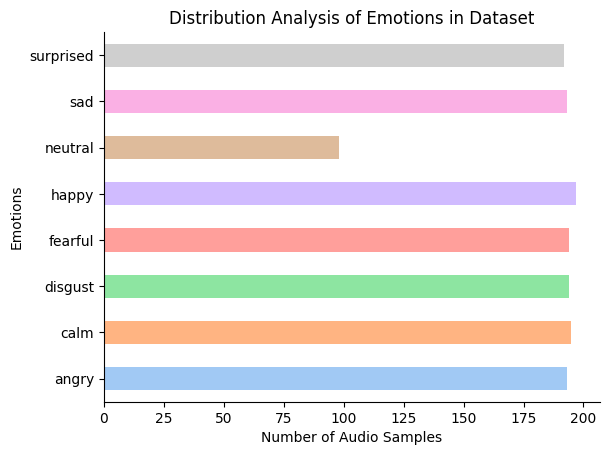

In [18]:
pastel_palette = sns.color_palette('pastel')
speech_df.groupby('Emotions').size().plot(kind='barh', color=pastel_palette)
plt.title('Distribution Analysis of Emotions in Dataset')
plt.xlabel('Number of Audio Samples')
plt.ylabel('Emotions')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [19]:
# Checking whether there is balance or imbalance in the dataset
data_checking = speech_df['Emotions'].value_counts()
print(data_checking)

Emotions
happy        197
calm         195
disgust      194
fearful      194
sad          193
angry        193
surprised    192
neutral       98
Name: count, dtype: int64


In [20]:
# Specifying the percentages of each emotion available in the dataset
total_samples = data_checking.sum()
class_percentage = (data_checking / total_samples) * 100
print(class_percentage)

Emotions
happy        13.530220
calm         13.392857
disgust      13.324176
fearful      13.324176
sad          13.255495
angry        13.255495
surprised    13.186813
neutral       6.730769
Name: count, dtype: float64


### **Preprocessing**

In [21]:
# Here extracting the features for applying the preprocessing steps
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed
speech_df['Features'] = speech_df['Path'].apply(lambda x: extract_features(x))

In [22]:
# fitting the label encoder on emotions
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(speech_df['Emotions'])
X_features = np.array(speech_df['Features'].tolist())

In [23]:
#To balance the dataset
smote_esr = SMOTE(random_state=42)
X_balanced, y_balanced = smote_esr.fit_resample(X_features, y_encoded)
y_balanced_labels = encoder.inverse_transform(y_balanced)

In [24]:
#Balanced the dataset
balanced_df = pd.DataFrame(X_balanced, columns=[f'Feature_{i}' for i in range(X_balanced.shape[1])])
balanced_df['Emotions'] = y_balanced_labels
print(balanced_df['Emotions'].value_counts())

Emotions
neutral      197
calm         197
surprised    197
sad          197
angry        197
disgust      197
happy        197
fearful      197
Name: count, dtype: int64


In [25]:
#standardising the features
scaler = StandardScaler()
x_features = scaler.fit_transform(X_balanced)

### **Model** **Building**

## 4 different models are used for classification task







[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100building tree 10 of 100

building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100building tree 53 of 100

building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100building tree 81 of 100

building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.76      0.72      0.74        40
           1       0.79      0.85      0.81        39
           2       0.54      0.67      0.60        39
           3       0.63      0.67      0.65        39
           4       0.70      0.40      0.51        40
           5       0.83      0.97      0.90        40
           6       0.66      0.62      0.64        40
           7       0.77      0.77      0.77        39

    accuracy                           0.71       316
   macro avg       0.71      0.71      0.70       316
weighted avg       0.71      0.71      0.70       316



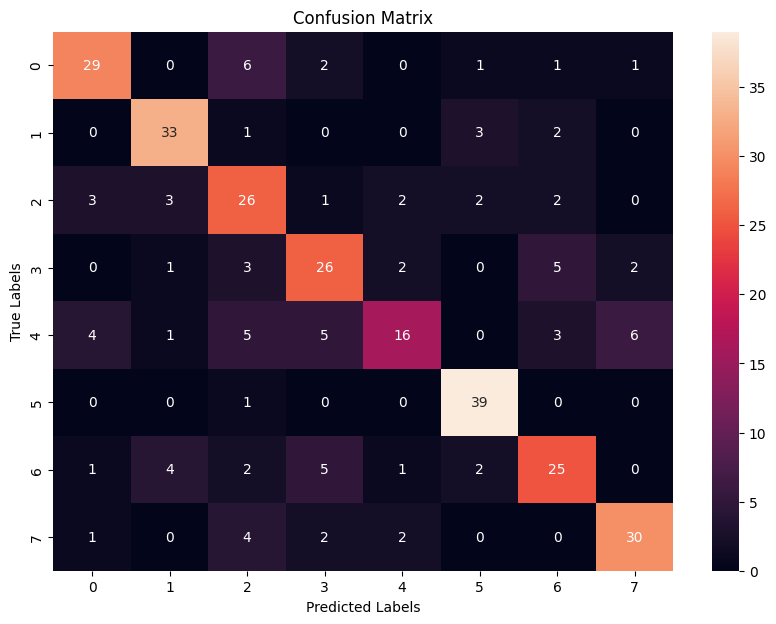

In [26]:
# splitting the dataset into train and test and building the model
X_train, X_test, y_train, y_test = train_test_split(x_features, y_balanced, test_size=0.2, random_state=22, stratify=y_balanced)
model = RandomForestClassifier(n_estimators=100, random_state=39,verbose = 2,n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
cm_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
random_pipeline = Pipeline([
    ('scaler', scaler),
    ('random_model', model)
])

In [28]:
svm_model = SVC(kernel='linear', C=5, random_state=49,verbose = 2,max_iter =900000,degree = 4)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

[LibSVM]              precision    recall  f1-score   support

           0       0.52      0.62      0.57        40
           1       0.61      0.64      0.62        39
           2       0.47      0.56      0.51        39
           3       0.57      0.54      0.55        39
           4       0.38      0.42      0.40        40
           5       0.67      0.78      0.72        40
           6       0.48      0.35      0.41        40
           7       0.61      0.36      0.45        39

    accuracy                           0.53       316
   macro avg       0.54      0.53      0.53       316
weighted avg       0.54      0.53      0.53       316



In [39]:
svm_pipeline = Pipeline([
    ('scaler', scaler),
    ('svm_model', svm_model)
])

In [42]:
model_filename = 'svm_emotion_recognition_model.joblib'
joblib.dump(svm_pipeline, model_filename)
print("SVM model saved as", model_filename)

SVM model saved as svm_emotion_recognition_model.joblib


In [29]:
loo = LeaveOneOut()
num_splits = loo.get_n_splits(X_train)
print(f"Total number of splits: {num_splits}")

Total number of splits: 1260


In [30]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [31]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.80      0.67        40
           1       0.72      0.85      0.78        39
           2       0.63      0.74      0.68        39
           3       0.61      0.77      0.68        39
           4       0.61      0.28      0.38        40
           5       0.78      0.90      0.84        40
           6       0.77      0.50      0.61        40
           7       0.83      0.64      0.72        39

    accuracy                           0.68       316
   macro avg       0.69      0.68      0.67       316
weighted avg       0.69      0.68      0.67       316

Accuracy: 0.6835443037974683


In [41]:
knn_pipeline = Pipeline([
    ('scaler', scaler),
    ('knn_model', knn)
])

In [43]:
model_filename = 'knn_emotion_recognition_model.joblib'
joblib.dump(knn_pipeline, model_filename)
print("KNN model saved as", model_filename)

KNN model saved as knn_emotion_recognition_model.joblib


In [32]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
predictions = model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.5537974683544303
              precision    recall  f1-score   support

           0       0.70      0.75      0.72        40
           1       0.65      0.56      0.60        39
           2       0.52      0.56      0.54        39
           3       0.51      0.46      0.49        39
           4       0.49      0.45      0.47        40
           5       0.60      0.70      0.64        40
           6       0.49      0.42      0.45        40
           7       0.47      0.51      0.49        39

    accuracy                           0.55       316
   macro avg       0.55      0.55      0.55       316
weighted avg       0.55      0.55      0.55       316



In [44]:
Log_Reg_pipeline = Pipeline([
    ('scaler', scaler),
    ('Log_model', model_lr)
])

In [45]:
model_filename = 'Logistic_Regression_emotion_recognition_model.joblib'
joblib.dump(Log_Reg_pipeline, model_filename)
print("Logistic Regression model saved as", model_filename)

Logistic Regression model saved as Logistic_Regression_emotion_recognition_model.joblib


In [34]:
import joblib
model_filename = 'random_emotion_recognition_model.joblib'
joblib.dump(random_pipeline, model_filename)
print("Optimized random model saved as", model_filename)

Optimized random model saved as random_emotion_recognition_model.joblib


In [35]:
audio_path = '/content/drive/MyDrive/ML_Project/yaswanth.wav'
Audio(audio_path)

In [36]:
# audio from Rajinikanth Kabali Movie
audio_path = '/content/drive/MyDrive/angry.wav'
Audio(audio_path)

### **QUICK** **DEMO**

In [37]:
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    if len(audio) < 1024:
        audio = np.pad(audio, pad_width=(1024 - len(audio), 0), mode='constant', constant_values=(0, 0))

    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=15)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate, n_chroma=12)
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=20)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate, n_bands=6)
    tonnetz = librosa.feature.tonnetz(y=audio, sr=sample_rate)

    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel, axis=1),
        np.mean(contrast, axis=1),
        np.mean(tonnetz, axis=1)
    ])

    return features

def predict_emotion_from_audio(file_path, model_path):

    features = extract_features(file_path)
    features = features.reshape(1, -1)
    model = joblib.load(model_path)


    emotion_label = model.predict(features)[0]
    return emotion_label


emotion_mapping = {
    0: 'Neutral',
    1: 'Calm',
    2: 'Happy',
    3: 'Sad',
    4: 'Angry',
    5: 'Fearful',
    6: 'Disgust',
    7: 'Surprised'
}

# Usage example
file_path = '/content/drive/MyDrive/angry.wav'
model_path = '/content/random_emotion_recognition_model.joblib'
predicted_label = predict_emotion_from_audio(file_path, model_path)
emotion = emotion_mapping.get(predicted_label, "Unknown Emotion")
print("Predicted Emotion:", emotion)

Predicted Emotion: Angry


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
